<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/abtem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Simulate particles of proteins with abtem

# Resources
https://abtem.readthedocs.io/en/latest/walkthrough/introduction.html



# Setup

In [4]:
%%bash
pip install abtem

In [16]:
%%bash
rm -r abTEM
git clone https://github.com/jacobjma/abTEM.git
cp abTEM/abtem/*py /usr/local/lib/python3.6/dist-packages/abtem/
#cat /usr/local/lib/python3.6/dist-packages/abtem/waves.py | sed 's/kernel, overwrite_x=False/kernel/' > waves_patch.py
cat /usr/local/lib/python3.6/dist-packages/abtem/waves.py | sed 's/_crop_to_center/crop_to_center/' > waves_patch.py
mv waves_patch.py /usr/local/lib/python3.6/dist-packages/abtem/waves.py
rm -r /usr/local/lib/python3.6/dist-packages/abtem/__pycache__/

Cloning into 'abTEM'...
rm: cannot remove '/usr/local/lib/python3.6/dist-packages/abtem/__pycache__/': No such file or directory


In [19]:
%%bash
cat -n /usr/local/lib/python3.6/dist-packages/abtem/waves.py | grep crop_to_center

     9	from abtem.detect import AbstractDetector, crop_to_center
   171	        pattern = asnumpy(abs2(crop_to_center(xp.fft.fftshift(fft2(self.array, overwrite_x=False)))))


In [18]:
%%bash
cat -n /usr/local/lib/python3.6/dist-packages/abtem/detect.py | grep crop_to_center

    15	def crop_to_center(array: np.ndarray):
    31	    intensity = crop_to_center(xp.fft.fftshift(array, axes=(-2, -1)))
   301	        intensity = crop_to_center(intensity)


In [85]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from ase.io import read, proteindatabank
from abtem.plot import show_atoms
from abtem.potentials import Potential

from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave
from abtem.transfer import CTF, scherzer_defocus


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Visualize protein atoms from pdb file

In [34]:
from ase.io import read, proteindatabank


# Examples

## IP3

In [ ]:
%%bash
wget http://ligand-expo.rcsb.org/reports/I/I3P/I3P_ideal.pdb

--2020-08-17 18:10:47--  http://ligand-expo.rcsb.org/reports/I/I3P/I3P_ideal.pdb
Resolving ligand-expo.rcsb.org (ligand-expo.rcsb.org)... 128.6.150.17
Connecting to ligand-expo.rcsb.org (ligand-expo.rcsb.org)|128.6.150.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3946 (3.9K) [chemical/x-pdb]
Saving to: ‘I3P_ideal.pdb’

     0K ...                                                   100% 62.1K=0.06s

2020-08-17 18:10:48 (62.1 KB/s) - ‘I3P_ideal.pdb’ saved [3946/3946]



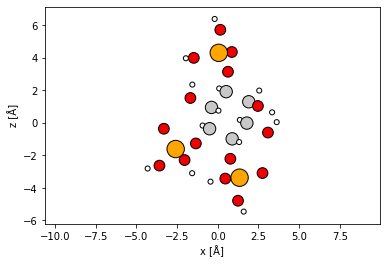

In [ ]:
atoms = proteindatabank.read_proteindatabank('I3P_ideal.pdb')
show_atoms(atoms, plane='xz')

## nanotube

In [ ]:
from ase.build import nanotube
atoms = nanotube(6, 4, length=1)

## small protein from PDB

In [ ]:
%%bash
wget https://files.rcsb.org/view/6B17.pdb # didn't work 1VRZ

--2020-08-04 17:34:05--  https://files.rcsb.org/view/6B17.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.244.94
Connecting to files.rcsb.org (files.rcsb.org)|128.6.244.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘6B17.pdb’

     0K .......... .......... .......... .......... ..........  317K
    50K .......... .......... .......... .......... ..........  635K
   100K .......... .......... .......... .......... .......... 94.8M
   150K .......... .......... .......... ........               490K=0.3s

2020-08-04 17:34:06 (598 KB/s) - ‘6B17.pdb’ saved [192780]



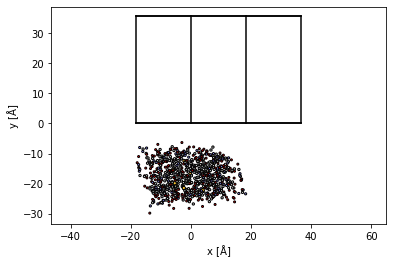

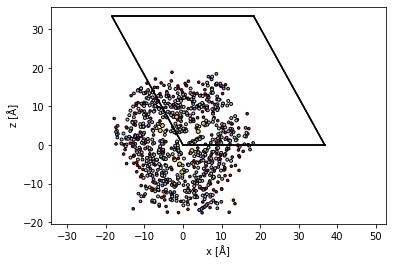

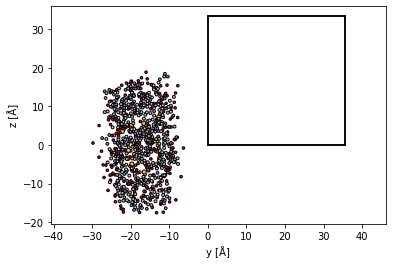

In [ ]:
atoms = proteindatabank.read_proteindatabank('6B17.pdb')
show_atoms(atoms, plane='xy')
show_atoms(atoms, plane='xz')
show_atoms(atoms, plane='yz')

## IP3R

In [22]:
%%bash
wget https://files.rcsb.org/download/1N4K.pdb # IP3R Mitsu's 2002 IP3 bound structure


--2020-08-17 19:28:53--  https://files.rcsb.org/download/1N4K.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.213.55
Connecting to files.rcsb.org (files.rcsb.org)|132.249.213.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1N4K.pdb’

     0K .......... .......... .......... .......... ..........  193K
    50K .......... .......... .......... .......... ..........  386K
   100K .......... .......... .......... .......... ..........  385K
   150K .......... .......... .......... .......... .......... 91.1M
   200K .......... .......... .......... ........               129M=0.5s

2020-08-17 19:28:54 (460 KB/s) - ‘1N4K.pdb’ saved [244377]



In [23]:
atoms = proteindatabank.read_proteindatabank('1N4K.pdb')


In [24]:
atoms.get_positions().min(0)

array([-15.783, -21.359,  -5.704])

In [25]:
atoms.get_positions().max(0)

array([38.954, 40.914, 53.477])

## visualize

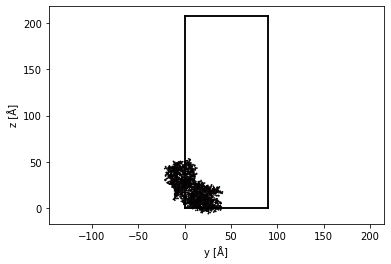

In [26]:
from abtem.plot import show_atoms
# a,b,c = 10,20,10
# atoms.set_cell([(a,0,0),(0,b,0),(0,0,c)])

show_atoms(atoms, plane='yz')

## centre and pad

In [27]:
pad = 10 # A
atoms.set_positions(atoms.get_positions() - atoms.get_positions().min(0) + pad*np.ones(3))

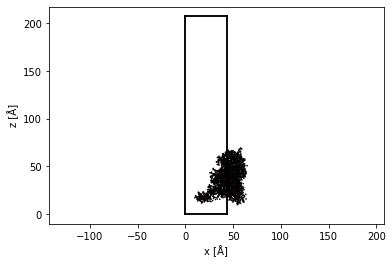

In [28]:
show_atoms(atoms, plane='xz')

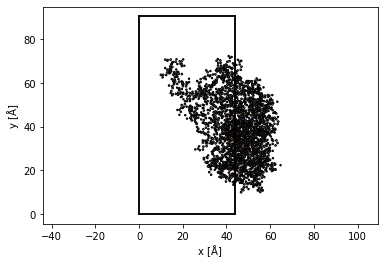

In [167]:
show_atoms(atoms, plane='xy')

## cell and pad

In [29]:
atoms.set_cell(atoms.get_positions().max(0) + pad)

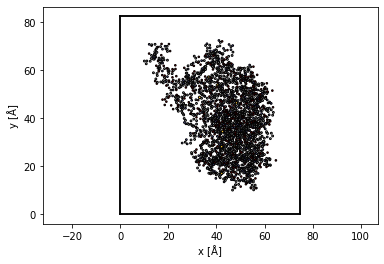

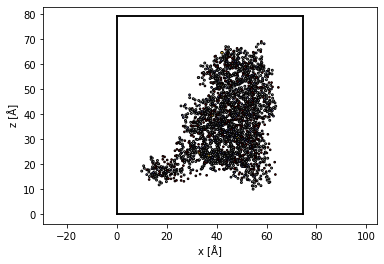

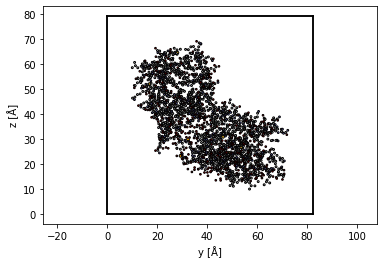

In [30]:
show_atoms(atoms, plane='xy')
show_atoms(atoms, plane='xz')
show_atoms(atoms, plane='yz')

# Calculate potential
Independent atom model

In [31]:
from abtem.potentials import Potential

In [59]:
potential = Potential(atoms, 
                      sampling=0.075,
                      parametrization='lobato',
                      slice_thickness=0.075)


In [60]:
potential._storage = 'gpu'
precalculated_potential = potential.build(pbar=True)#potential.build(pbar=True)
precalculated_potential_arr = cp.asnumpy(precalculated_potential.array)

In [61]:
x,y,z = (2*pad + atoms.get_positions().max(0) - atoms.get_positions().min(0)) / np.array([0.03,0.03,0.5])
print(precalculated_potential_arr.shape)  # z x y
print(z,x,y)

(1056, 997, 1097)
158.362 2491.233333333333 2742.4333333333334


In [102]:
%%bash
mkdir -p /content/drive/My\ Drive/repos/abtem/data

In [103]:
np.save('/content/drive/My Drive/repos/abtem/data/1n4k_IP3R_potential_20200817',precalculated_potential.array)

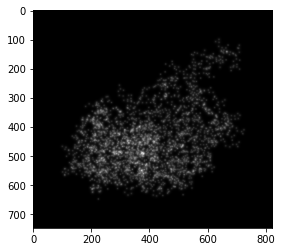

In [52]:
image = precalculated_potential_arr.mean(axis=0)
plt.imshow(image,cmap='gray')

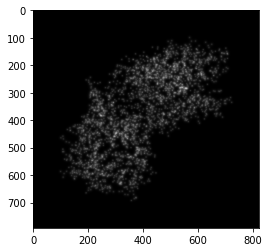

In [53]:
image = precalculated_potential_arr.mean(axis=1)
plt.imshow(image,cmap='gray')

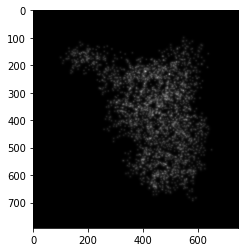

In [54]:
image = precalculated_potential_arr.mean(axis=2)
plt.imshow(image,cmap='gray')

# Wave functions

In [63]:
from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave
wave = PlaneWave(energy=300e3)


In [64]:
wave.energy

300000.0

# Multislice simulations

In [65]:
wave = PlaneWave(energy=300e3)

wave.grid.match(potential)

wave = wave.build()

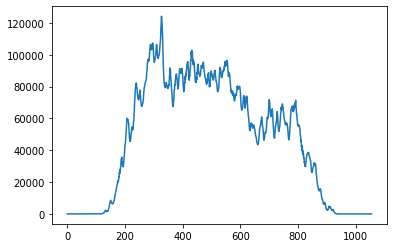

In [66]:
import pandas as pd
pd.Series(cp.asnumpy(precalculated_potential.array.sum(axis=(1,2)))).plot()

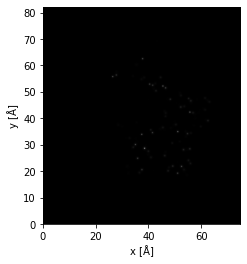

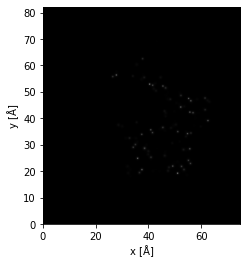

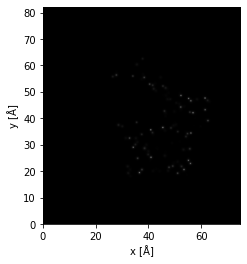

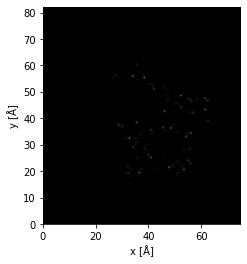

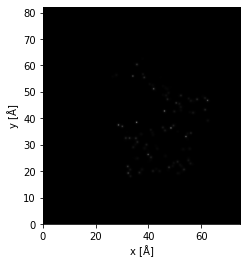

In [77]:
for i in range(precalculated_potential.array.shape[0]//2,precalculated_potential.array.shape[0]//2 + 10,2): potential[i].show()

KeyboardInterrupt: ignored

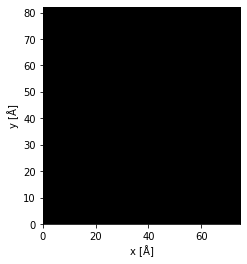

In [78]:
from abtem.waves import FresnelPropagator, transmit

propagator = FresnelPropagator()
wave = PlaneWave(energy=300e3)
wave.device = 'gpu'
wave.grid.match(potential)
wave = wave.build()
wave.show()
for i in range(potential.num_slices):
  potential_slice = potential[i]
  transmit(wave, potential_slice)
  propagator.propagate(wave, potential_slice.thickness)

wave.show()

In [107]:
potential = Potential(atoms, 
                      sampling=0.1,
                      parametrization='lobato',
                      slice_thickness=0.1)


exit_wave = PlaneWave(energy=300e3,sampling=.1).multislice(potential)
ewa = exit_wave.array.copy()


In [108]:
np.save('/content/drive/My Drive/repos/abtem/data/20200817_1n4k_IP3R_exitwave', exit_wave.array[0])

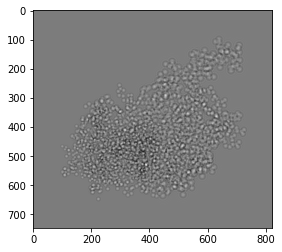

In [109]:
plt.imshow(exit_wave.array[0].real,cmap='gray')

# CTF

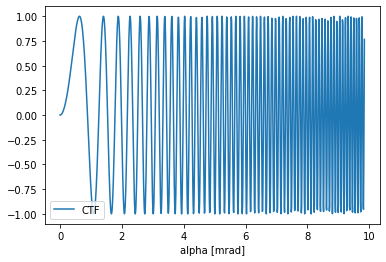

In [82]:
from abtem.transfer import CTF
ctf = CTF(defocus=2.5e4, # 2.5 um
          Cs=2e7, # 2 mm
          energy=3e5 # 300 kV
          )
k = 1/2 # A-1
lam = wave.wavelength
semiangle_cutoff = k*lam*1000
ctf.show(semiangle_cutoff=semiangle_cutoff)

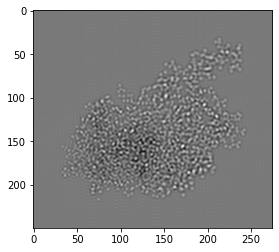

In [83]:
plt.imshow(exit_wave.array[0].real,cmap='gray')

Scherzer defocus

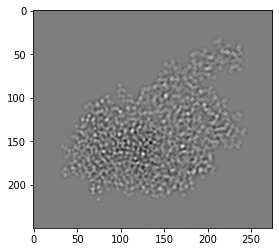

In [94]:
from abtem.utils import spatial_frequencies, polargrid
from abtem import device
xp=np

#ctf = CTF(defocus=2.5e4,Cs=2e7,energy=3e5)
Cs = -7e-6 * 1e10
ctf = CTF(Cs=Cs, energy=300e3)
ctf.defocus = scherzer_defocus(Cs, ctf.energy)
kx, ky = spatial_frequencies(exit_wave.grid.gpts, exit_wave.grid.sampling)
alpha, phi = polargrid(xp.asarray(kx * wave.wavelength), xp.asarray(ky * exit_wave.wavelength))
kernel = ctf.evaluate(alpha, phi)
psi_ctf_r = device.fft2_convolve(exit_wave.array[0], kernel, overwrite_x=False)

plt.imshow(psi_ctf_r.real,cmap='gray')

Typical cryoEM defocus

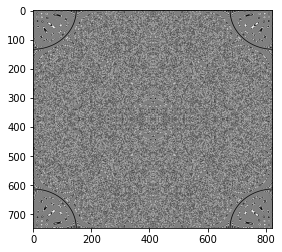

In [110]:
from abtem.utils import spatial_frequencies, polargrid
xp=np

ctf = CTF(defocus=2.5e4,Cs=2e7,energy=3e5)
kx, ky = spatial_frequencies(exit_wave.grid.gpts, exit_wave.grid.sampling)
alpha, phi = polargrid(xp.asarray(kx * exit_wave.wavelength), xp.asarray(ky * exit_wave.wavelength))
kernel = ctf.evaluate(alpha, phi)
#plt.imshow(kernel.real,cmap='gray')
plt.imshow(kernel.imag,cmap='gray')


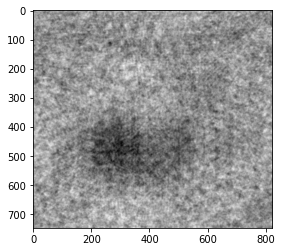

In [111]:

psi_ctf_r = device.fft2_convolve(exit_wave.array[0], kernel, overwrite_x=False)

plt.imshow(psi_ctf_r.real,cmap='gray')

Depending on the size of our object, the defocused image will resemble it.

In [97]:
from abtem.transfer import CTF, scherzer_defocus
exit_wave.apply_ctf(defocus=2.5e4,Cs=2e7,energy=3e5) # does iFT[FT[wave]CTF]

In [98]:
ewa2 = exit_wave.array.copy()

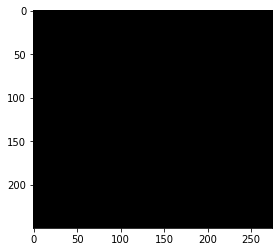

In [99]:
plt.imshow(np.isclose(ewa[0],ewa2[0],atol=1e-2),cmap='gray')

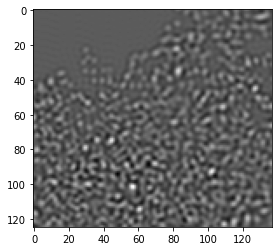

In [193]:
from abtem.detect import crop_to_center
I = np.abs(exit_wave.array[0])**2
I = crop_to_center(I)
plt.imshow(np.log(np.abs(I)+1),cmap='gray')
#plt.imshow(np.log(np.abs(I)+1),cmap='gray')

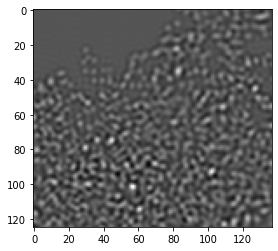

In [194]:
plt.imshow(I,cmap='gray')

# Detect

In [195]:
from abtem.detect import PixelatedDetector

In [196]:
detector = PixelatedDetector()
intensity = detector.detect(wave)

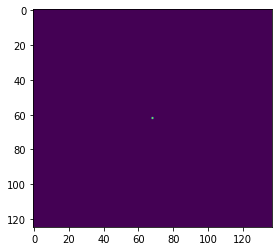

In [197]:
plt.imshow(intensity)

# Image formation
$I_0 = |F^{-1}[F[\Psi_{exit}]CTF]|^2$

In [208]:
exit_wave = PlaneWave(energy=300e3,sampling=.3).multislice(potential)
ewa = exit_wave.array.copy()

In [100]:
ctf = CTF(defocus=2.5e4, # 2.5 um
          Cs=2e7, # 2 mm
          energy=3e5 # 300 kV
          )
exit_wave.apply_ctf(ctf)

In [101]:
ewa_ = exit_wave.array.copy()
np.allclose(ewa,ewa_)

True

# scratch

In [ ]:
%%bash
rm /usr/local/lib/python3.6/dist-packages/abtem/data/*txt
rm lobato* kirkland*

for STR in lobato kirkland;
do
  wget https://raw.githubusercontent.com/jacobjma/abTEM/661238b8da6e59df8e9dd17cdbe20503b3e7aabc/data/$STR.txt
  mkdir -p /usr/local/lib/python3.6/dist-packages/abtem/data/
  mv ${STR}.txt /usr/local/lib/python3.6/dist-packages/abtem/data/$STR.txt
done



In [ ]:
%%bash
cat -n /usr/local/lib/python3.6/dist-packages/abtem/device.py

In [ ]:
%%bash
cat /usr/local/lib/python3.6/dist-packages/abtem/waves.py | sed 's/kernel, overwrite_x=False/kernel/' | grep fft2_convolve
#self.array, kernel, overwrite_x=False/HELLOOOO//

        fft2_convolve = get_device_function(get_array_module(waves.array), 'fft2_convolve')
        fft2_convolve(waves._array, propagator_array)
        fft2_convolve = get_device_function(get_array_module(self.array), 'fft2_convolve')
        return self.__class__(fft2_convolve(self.array, kernel),


In [ ]:
path = '/usr/local/lib/python3.6/dist-packages/data/lobato.txt'
with open(path, 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  keys = next(reader)
  print(keys)

['1', '0.00647384848835291', '-0.49019257678022900', '0.57328416039087600', '-0.37940330148399000', '0.55442647477407900', '2.78519885379148000', '2.77620428330644000', '2.77538591050625000', '2.76759302867258000', '2.76511897642927000']


In [ ]:
fname = '/usr/local/lib/python3.6/dist-packages/data/lobato.txt'
import os
import csv
import numpy as np

def load_parameters(filename):
    path = filename#os.path.join(os.path.dirname(os.path.abspath(__file__)), filename)
    parameters = {}
    with open(path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        keys = next(reader)
        for _, row in enumerate(reader):
            values = list(map(float, row))
            parameters[int(row[0])] = dict(zip(keys, values))
    return parameters
    
def load_lobato_parameters():
    parameters = {}

    for key, value in load_parameters(fname).items():
        a = np.array([value[key] for key in ('a1', 'a2', 'a3', 'a4', 'a5')])
        b = np.array([value[key] for key in ('b1', 'b2', 'b3', 'b4', 'b5')])
        a = np.pi ** 2 * a / b ** (3 / 2.)
        b = 2 * np.pi / np.sqrt(b)
        parameters[key] = np.vstack((a, b))

    return parameters

In [ ]:
parameters = load_lobato_parameters()

KeyError: ignored